### Load the packages

In [27]:
import pandas as pd
import numpy as np
import tensorflow as tf
import os, glob
import cv2
import seaborn as sns
import matplotlib.pyplot as plt

from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Dense, Flatten, BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.preprocessing import LabelEncoder

from keras_vggface.vggface import VGGFace
from keras_vggface import utils
from keras_vggface.utils import preprocess_input
from PIL import Image

from keras.models import Model, Sequential
from keras.layers import Flatten, Dense, Input, Conv2D, Reshape, MaxPooling2D
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import load_img, img_to_array

from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_squared_log_error, r2_score

from keras.callbacks import EarlyStopping, LearningRateScheduler
from scipy.stats import pearsonr



### Load the dataset

In [2]:
# Load the data
data = pd.read_csv('/Users/kajalshukla/Desktop/Quarter-3/ML & Predictive Analytics/ML_Final_Project/BMI/Data/data.csv')


### Set the path to the directory containing the images

In [3]:
# set the path to the directory containing the images
image_dir = "/Users/kajalshukla/Desktop/Quarter-3/ML & Predictive Analytics/ML_Final_Project/BMI/Data/Images"


### Drop the first column

In [4]:
data = data.iloc[:, 1:]
data.head()

,bmi,gender,is_training,name
0,34.207396,Male,1,img_0.bmp
1,26.453720,Male,1,img_1.bmp
2,34.967561,Female,1,img_2.bmp
3,22.044766,Female,1,img_3.bmp
4,37.758789,Female,1,img_4.bmp


### Split the data into training and test sets

In [5]:
# Split the data into training and test sets 
train_data = data[data['is_training'] == 1]
test_data = data[data['is_training'] == 0]

### Filter the train and test dataset based on images in the image directory

In [6]:
# Filter the train dataset based on images in the image directory
train_data = train_data[train_data['name'].apply(lambda x: os.path.exists(os.path.join(image_dir, x)))]


In [7]:
# Filter the train dataset based on images in the image directory
test_data = test_data[test_data['name'].apply(lambda x: os.path.exists(os.path.join(image_dir, x)))]


### Check the shape of both train and test dataset

In [8]:
train_data.shape

(3210, 4)

In [9]:
test_data.shape

(752, 4)

### Check for missing values

In [58]:
train_data.isnull().sum()

bmi            0
gender         0
is_training    0
name           0
dtype: int64

In [59]:
test_data.isnull().sum()

bmi            0
gender         0
is_training    0
name           0
dtype: int64

### There are no null values 

### Perform Basic EDA

In [60]:
print(train_data["bmi"].describe())

count    3210.000000
mean       32.434370
std         8.017202
min        17.716216
25%        26.317568
50%        30.996473
75%        37.118916
max        81.211930
Name: bmi, dtype: float64


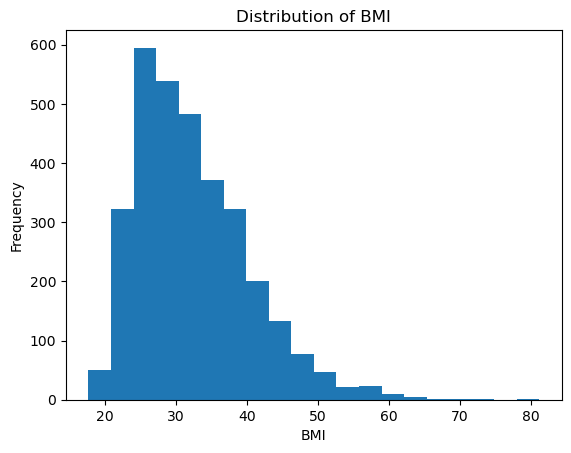

In [61]:
# Visualize BMI distribution
plt.hist(train_data["bmi"], bins=20)
plt.xlabel("BMI")
plt.ylabel("Frequency")
plt.title("Distribution of BMI")
plt.show()

### Load training images and BMI

In [15]:

train_images = []
train_bmi = []
for index, row in train_data.iterrows():
    image_path = os.path.join(image_dir, row['name'])
    img = cv2.imread(image_path)
    img = cv2.resize(img, (224, 224))
    train_images.append(img)
    bmi = row['bmi']  # Get the BMI value for the current image
    train_bmi.append(bmi)  # Append the BMI value to the train_bmi array

### Load test images and BMI

In [17]:
test_images = []
test_bmi = []
for index, row in test_data.iterrows():
    image_path = os.path.join(image_dir, row['name'])
    img = cv2.imread(image_path)
    img = cv2.resize(img, (224, 224))
    test_images.append(img)
    bmi = row['bmi']  # Get the BMI value for the current image
    test_bmi.append(bmi)  # Append the BMI value to the train_bmi array

In [ ]:
test_bmi

### Convert the images to a numpy array

In [20]:
train_images = np.array(train_images) / 255.0
train_bmi = np.array(train_bmi)
test_images = np.array(test_images) / 255.0
test_bmi = np.array(test_bmi)

In [21]:
print(train_images.shape)
print(train_bmi.shape)
print(test_images.shape)
print(test_bmi.shape)

(3210, 224, 224, 3)
(3210,)
(752, 224, 224, 3)
(752,)


### Build and Train VGG Face Model

In [28]:
vgg_model = VGGFace(model='vgg16', 
                    include_top=False, 
                    input_shape=(224, 224, 3), 
                    pooling='max')

In [29]:
# Freeze all layers except for the last 3 layers
for layer in vgg_model.layers[:-3]:
    layer.trainable = False

In [30]:
# Add new layers to the model
x = vgg_model.output
x = Flatten()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(1, activation='linear')(x)


In [35]:
# define the early stopping callback
early_stop = EarlyStopping(monitor='mse', patience=3, verbose=1)

In [36]:
# Create custom VGG16 model
custom_vgg_model = Model(inputs=vgg_model.input, outputs=output)

In [37]:
# Compile the model
learning_rate = 0.001
custom_vgg_model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mean_squared_error', metrics=['mse'])


In [38]:
custom_vgg_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1_1 (Conv2D)            (None, 224, 224, 64)      1792      
                                                                 
 conv1_2 (Conv2D)            (None, 224, 224, 64)      36928     
                                                                 
 pool1 (MaxPooling2D)        (None, 112, 112, 64)      0         
                                                                 
 conv2_1 (Conv2D)            (None, 112, 112, 128)     73856     
                                                                 
 conv2_2 (Conv2D)            (None, 112, 112, 128)     147584    
                                                                 
 pool2 (MaxPooling2D)        (None, 56, 56, 128)       0   

### Fitting the model

In [39]:
custom_vgg_model.fit(train_images, train_bmi,
                     epochs=3, 
                     batch_size=32,
                    callbacks = [early_stop])

Epoch 1/3


2023-05-20 16:14:36.124080: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


101/101 [==============================] - 583s 6s/step - loss: 111.7439 - mse: 111.7439
Epoch 2/3
101/101 [==============================] - 569s 6s/step - loss: 63.6502 - mse: 63.6502
Epoch 3/3
101/101 [==============================] - 568s 6s/step - loss: 49.1771 - mse: 49.1771


### Evaluating the model

In [40]:
# Evaluate the model on TEST data
loss, mse = custom_vgg_model.evaluate(test_images, test_bmi)

# Print the scores
print("Test Loss:", loss)
print("Test MSE:", mse)

24/24 [==============================] - 132s 6s/step - loss: 67.1103 - mse: 67.1103
Test Loss: 67.11026763916016
Test MSE: 67.11026763916016


In [41]:
# Evaluate the model on TRAIN data
train_loss, train_mse = custom_vgg_model.evaluate(train_images, train_bmi)
print('Training Loss:', train_loss)
print('Training Accuracy:', train_mse)

101/101 [==============================] - 495s 5s/step - loss: 22.2324 - mse: 22.2324
Training Loss: 22.23244285583496
Training Accuracy: 22.23244285583496


### Predicting BMI

In [42]:
# Step 6: Use the model to make predictions on the test set
# predictions = model.predict(test_images)

predicted_bmis = custom_vgg_model.predict(test_images)


24/24 [==============================] - 165s 7s/step


In [43]:
# Save the model to a file
custom_vgg_model.save('bmi_pred_model_v10.h5')
print("Saved model")

Saved model


In [44]:
preds = predicted_bmis.ravel()

### Compare Actual BMI vs Predicted BMI

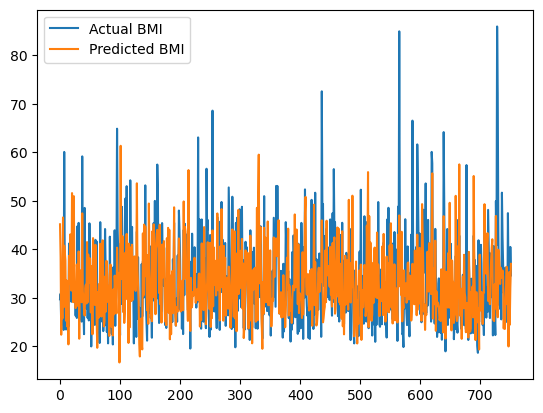

In [45]:
plt.plot(test_bmi, label='Actual BMI')
plt.plot(preds, label='Predicted BMI')
plt.legend()
plt.show()

In [46]:
mae = mean_absolute_error(test_bmi, preds)
print("Mean Absolute Error:", mae)

Mean Absolute Error: 5.937543901989309


In [47]:
mse = mean_squared_error(test_bmi, preds)
print("Mean Squared Error:", mse)

Mean Squared Error: 67.11026519586484


In [48]:
rmse = np.sqrt(mse)
print("RMSE:", rmse)

RMSE: 8.192085521762138


In [49]:
r2 = r2_score(test_bmi, preds)
print("R-squared:", r2)

R-squared: 0.20947072688714785


In [50]:
correlation, p_value = pearsonr(test_bmi, preds)

print("Pearson correlation:", correlation)
print("p-value:", p_value)


Pearson correlation: 0.5232506414557332
p-value: 4.3862558501209695e-54


# TESTING ON THE IMAGE

In [51]:
# set the path to the directory containing the images
path = "/Users/kajalshukla/Desktop/Quarter-3/ML & Predictive Analytics/ML_Final_Project/Final_Project"
model_path = os.path.join(path, 'bmi_pred_model_v10.h5')
model = load_model(model_path)

In [57]:
# Load and preprocess the image
img = Image.open("/Users/kajalshukla/Desktop/img_4202.bmp")
# img = Image.open("/Users/kajalshukla/Desktop/img_4200.bmp")
img = img.resize((224, 224))
img = np.expand_dims(img, axis=0)
img = np.array(img) / 255.0

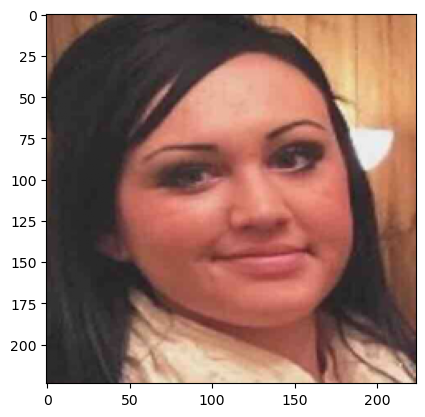

In [53]:
# Step 4: Visualize instance 
plt.imshow(img.squeeze())
plt.show()


In [54]:
# Make a prediction on the image
predicted_bmi = model.predict(img)

1/1 [==============================] - 0s 416ms/step


In [55]:
predicted_bmi[0][0]

26.39846